<a href="https://colab.research.google.com/github/Kitsunnneee/Common-Task-2/blob/main/Common_Task_2(Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and Importing the neccessary dependencies

In [ ]:
import torch
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 13.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph

import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import GCNConv, GATConv, SAGEConv

# Mounting and Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5" #Path to the dataset on my google drive

with h5py.File(path, 'r') as f:
  X_jets = f['X_jets'][0:5000] # Working with only a subset of data due to computational limits
  y = f['y'][0:5000]
  print(f"X_jets shape : {X_jets.shape}, y : {y.shape}") # printing the shape of the images and amount

X_jets shape : (5000, 125, 125, 3), y : (5000,)


In [ ]:
X_jets = np.array(X_jets)
y = np.array(y)

# Creating the point cloud from the dataset

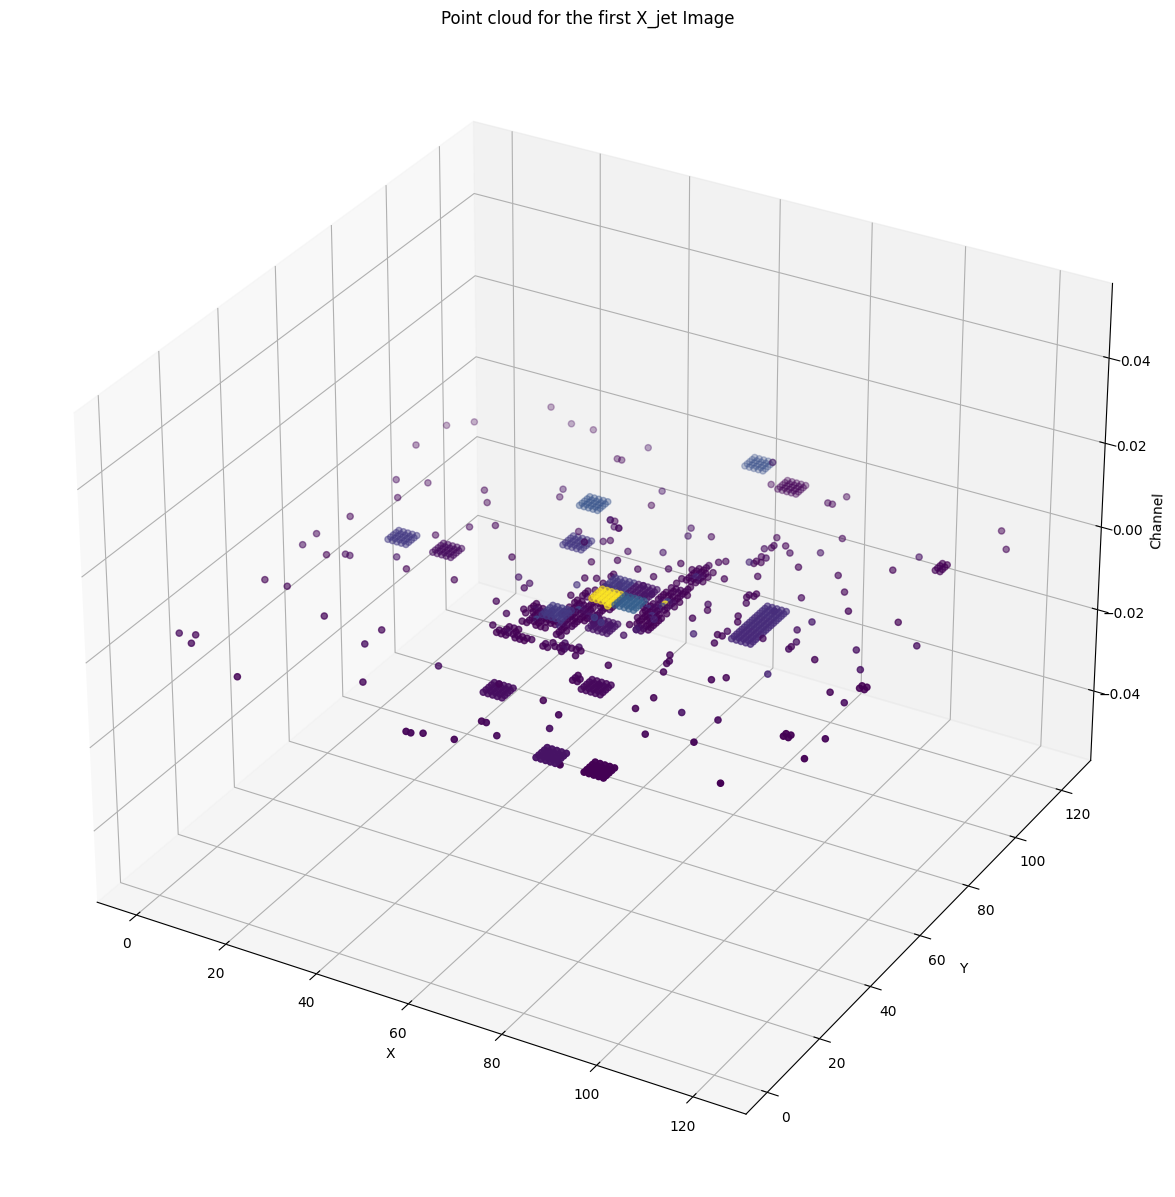

In [ ]:
size = X_jets.shape[0]
cloud = []
for i in range(size):
  #Selecting only the nonzero points
  nonzero_Track = np.nonzero(X_jets[i,:,:,0])
  nonzero_ECAL = np.nonzero(X_jets[i,:,:,1])
  nonzero_HCAL = np.nonzero(X_jets[i,:,:,2])

  #Getting the values of the respective channels
  valuesTrack = X_jets[i,nonzero_Track[0],nonzero_Track[1],0]
  valuesECAL = X_jets[i,nonzero_ECAL[0],nonzero_ECAL[1],1]
  valuesHCAL = X_jets[i,nonzero_HCAL[0],nonzero_HCAL[1],2]

  #Getting the co-ordinates of the respective channels
  coord_Track = np.hstack((np.column_stack(nonzero_Track), np.zeros((np.column_stack(nonzero_Track).shape[0],1))))
  coord_ECAL = np.hstack((np.column_stack(nonzero_ECAL), np.zeros((np.column_stack(nonzero_ECAL).shape[0],1))))
  coord_HCAL = np.hstack((np.column_stack(nonzero_HCAL), np.zeros((np.column_stack(nonzero_HCAL).shape[0],1))))


  cloud.append({"Track":(coord_Track, valuesTrack), "ECAL":(coord_ECAL, valuesECAL), "HCAL":(coord_HCAL, valuesHCAL)})


sample_cloud = cloud[0]

ax = plt.figure(figsize=(15,15)).add_subplot(111,projection='3d')

ax.scatter(sample_cloud["Track"][0][:,0],sample_cloud["Track"][0][:,1],sample_cloud["Track"][0][:,2],c=sample_cloud["Track"][1])
ax.scatter(sample_cloud["ECAL"][0][:,0],sample_cloud["ECAL"][0][:,1],sample_cloud["ECAL"][0][:,2],c=sample_cloud["ECAL"][1])
ax.scatter(sample_cloud["HCAL"][0][:,0],sample_cloud["HCAL"][0][:,1],sample_cloud["HCAL"][0][:,2],c=sample_cloud["HCAL"][1])

# sample_cloud['Track'

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel("Channel")
ax.set_title("Point cloud for the first X_jet Image")

plt.show()

# Converting the dataset to a graph format



In [ ]:
dataset = []

for i, x in enumerate(X_jets):
  flattened = x.reshape(-1,3)
  non_zero = np.any(flattened != (0,0,0), axis = -1)
  node = flattened[non_zero]
  edges = kneighbors_graph(node, 4, mode = 'connectivity',include_self = True)
  edges = edges.tocoo()
  data = Data(x=torch.from_numpy(node), edge_index=torch.from_numpy(np.vstack((edges.row,edges.col))).type(torch.long), edge_attr=torch.from_numpy(edges.data.reshape(-1,1)), y=torch.tensor([int(y[i])]))
  dataset.append(data)

In [ ]:

print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].num_nodes}')
print(f'Number of edges: {dataset[0].num_edges}')
print(f'Number of node features: {dataset[0].num_node_features}')
print(f'Number of edges features: {dataset[0].num_edge_features}')
print(dataset[0])

Number of graphs: 5000
Number of nodes: 884
Number of edges: 3536
Number of node features: 3
Number of edges features: 1
Data(x=[884, 3], edge_index=[2, 3536], edge_attr=[3536, 1], y=[1])


# Splitting the dataset to train, test and validation split

In [ ]:
train_loader = DataLoader(dataset[:4000], batch_size=32, shuffle=True)
test_loader = DataLoader(dataset[3000:4000], batch_size=32, shuffle=False)
val_loader = DataLoader(dataset[4000:], batch_size = 32, shuffle = False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining the traing and evaluation functions

In [ ]:
def train(model,loader,optimizer,criterion):
    model.train()
    correct = 0
    for data in loader:  # Iterate in batches over the training dataset.

         data = data.to(device)
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y) # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return loss, correct / len(loader.dataset)
def val(model,loader,optimizer,criterion):
  model.eval()
  correct = 0
  with torch.no_grad():
    for data in loader:
      data = data.to(device)
      out = model(data.x, data.edge_index, data.batch)
      loss = criterion(out, data.y) # Compute the loss.
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return loss, correct / len(loader.dataset)


# Defining and traing Model 1
This model is based on Graph Convolution.

In [ ]:
class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super(GCN, self).__init__()
    torch.manual_seed(42)
    self.conv1 = GCNConv(dataset[0].num_node_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, 2*hidden_channels)
    self.lin = Linear(2*hidden_channels, 2)

  def forward(self, x, edge_index, batch):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = self.conv2(x, edge_index)
    x = global_mean_pool(x, batch)

    x = F.dropout(x, p = 0.5, training = self.training)
    x = self.lin(x)

    return x

model = GCN(hidden_channels = 32).to(device)
print(model)


GCN(
  (conv1): GCNConv(3, 32)
  (conv2): GCNConv(32, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss().to(device)
best_valid_loss = float('inf')

for epoch in range(1, 31):
    train_loss, train_acc = train(model,train_loader,optimizer,criterion)
    val_loss, val_acc = val(model,val_loader,optimizer,criterion)
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'gcn-model.pt')
    print(f'Epoch: {epoch:03d},Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f} Val Acc : {val_acc:.4f}')

Epoch: 001,Train Loss: 0.7006, Train Acc: 0.4915, Val Loss: 0.6971 Val Acc : 0.5120
Epoch: 002,Train Loss: 0.6908, Train Acc: 0.5252, Val Loss: 0.6942 Val Acc : 0.5230
Epoch: 003,Train Loss: 0.6893, Train Acc: 0.5423, Val Loss: 0.6731 Val Acc : 0.4880
Epoch: 004,Train Loss: 0.6773, Train Acc: 0.5555, Val Loss: 0.6725 Val Acc : 0.6650
Epoch: 005,Train Loss: 0.6609, Train Acc: 0.6222, Val Loss: 0.6335 Val Acc : 0.7020
Epoch: 006,Train Loss: 0.6578, Train Acc: 0.6538, Val Loss: 0.5882 Val Acc : 0.7070
Epoch: 007,Train Loss: 0.5705, Train Acc: 0.6610, Val Loss: 0.5452 Val Acc : 0.7050
Epoch: 008,Train Loss: 0.6157, Train Acc: 0.6690, Val Loss: 0.5288 Val Acc : 0.6970
Epoch: 009,Train Loss: 0.6256, Train Acc: 0.6715, Val Loss: 0.5256 Val Acc : 0.6840
Epoch: 010,Train Loss: 0.5839, Train Acc: 0.6730, Val Loss: 0.5009 Val Acc : 0.7010
Epoch: 011,Train Loss: 0.5880, Train Acc: 0.6753, Val Loss: 0.4981 Val Acc : 0.7010
Epoch: 012,Train Loss: 0.7440, Train Acc: 0.6675, Val Loss: 0.4930 Val Acc :

In [ ]:
model.load_state_dict(torch.load('gcn-model.pt'))

test_loss, test_acc = val(model,test_loader,optimizer,criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.4f}')

Test Loss: 0.446 | Test Acc: 0.6880


# Defining and traing Model 2
This model is based on Graph Attention.

In [ ]:
class GAT(torch.nn.Module):
  def __init__(self, hidden_channels):
    super(GAT, self).__init__()
    torch.manual_seed(42)
    self.conv1 = GATConv(dataset[0].num_node_features, hidden_channels)
    self.conv2 = GATConv(hidden_channels, 2*hidden_channels)
    self.lin = Linear(2*hidden_channels, 2)

  def forward(self, x, edge_index, batch):
    x = self.conv1(x, edge_index)
    x = F.elu(x)
    x = self.conv2(x, edge_index)
    x = global_mean_pool(x, batch)

    x = F.dropout(x, p = 0.5, training = self.training)
    x = self.lin(x)

    return F.log_softmax(x, dim = 1)

model_2 = GAT(hidden_channels = 32).to(device)
print(model_2)

GAT(
  (conv1): GATConv(3, 32, heads=1)
  (conv2): GATConv(32, 64, heads=1)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss().to(device)
best_valid_loss = float('inf')

for epoch in range(1, 31):
    train_loss, train_acc = train(model_2,train_loader,optimizer,criterion)
    val_loss, val_acc = val(model_2,val_loader,optimizer,criterion)
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model_2.state_dict(), 'gat-model.pt')
    print(f'Epoch: {epoch:03d},Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f} Val Acc : {val_acc:.4f}')

Epoch: 001,Train Loss: 0.6944, Train Acc: 0.4948, Val Loss: 0.6968 Val Acc : 0.5120
Epoch: 002,Train Loss: 0.6935, Train Acc: 0.4983, Val Loss: 0.6944 Val Acc : 0.5120
Epoch: 003,Train Loss: 0.6937, Train Acc: 0.4985, Val Loss: 0.6923 Val Acc : 0.4880
Epoch: 004,Train Loss: 0.6923, Train Acc: 0.5082, Val Loss: 0.6905 Val Acc : 0.4880
Epoch: 005,Train Loss: 0.6894, Train Acc: 0.5065, Val Loss: 0.6905 Val Acc : 0.4880
Epoch: 006,Train Loss: 0.6945, Train Acc: 0.5088, Val Loss: 0.6908 Val Acc : 0.4880
Epoch: 007,Train Loss: 0.6926, Train Acc: 0.5140, Val Loss: 0.6919 Val Acc : 0.5170
Epoch: 008,Train Loss: 0.6954, Train Acc: 0.5045, Val Loss: 0.6891 Val Acc : 0.4880
Epoch: 009,Train Loss: 0.6940, Train Acc: 0.5232, Val Loss: 0.6863 Val Acc : 0.4880
Epoch: 010,Train Loss: 0.6931, Train Acc: 0.5268, Val Loss: 0.6919 Val Acc : 0.5520
Epoch: 011,Train Loss: 0.6897, Train Acc: 0.5523, Val Loss: 0.6877 Val Acc : 0.5810
Epoch: 012,Train Loss: 0.6929, Train Acc: 0.5515, Val Loss: 0.6657 Val Acc :

In [ ]:
model_2.load_state_dict(torch.load('gat-model.pt'))

test_loss, test_acc = val(model_2,test_loader,optimizer,criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.4f}')

Test Loss: 0.484 | Test Acc: 0.6700


# Defining and traing Model 3 (Selected model)
This model is based on Graph Sage.

In [ ]:
class GSage(torch.nn.Module):
  def __init__(self, hidden_channels):
    super(GSage, self).__init__()
    torch.manual_seed(42)
    self.conv1 = SAGEConv(3, hidden_channels)
    self.conv2 = SAGEConv(hidden_channels, 2*hidden_channels)
    self.lin = Linear(2*hidden_channels, 2)

  def forward(self, x, edge_index, batch):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = global_mean_pool(x, batch)

    x = F.dropout(x, p = 0.5, training = self.training)
    x = self.lin(x)

    return x
model_3 = GSage(hidden_channels = 32).to(device)
print(model_3)

GSage(
  (conv1): SAGEConv(3, 32, aggr=mean)
  (conv2): SAGEConv(32, 64, aggr=mean)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss().to(device)
best_valid_loss = float('inf')

for epoch in range(1, 31):
    train_loss, train_acc = train(model_3,train_loader,optimizer,criterion)
    val_loss, val_acc = val(model_3,val_loader,optimizer,criterion)
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model_3.state_dict(), 'sage-model.pt')
    print(f'Epoch: {epoch:03d},Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f} Val Acc : {val_acc:.4f}')

Epoch: 001,Train Loss: 0.6937, Train Acc: 0.5140, Val Loss: 0.6966 Val Acc : 0.5380
Epoch: 002,Train Loss: 0.6898, Train Acc: 0.5260, Val Loss: 0.7064 Val Acc : 0.5150
Epoch: 003,Train Loss: 0.6738, Train Acc: 0.5317, Val Loss: 0.6845 Val Acc : 0.6100
Epoch: 004,Train Loss: 0.6840, Train Acc: 0.5635, Val Loss: 0.6637 Val Acc : 0.6460
Epoch: 005,Train Loss: 0.6556, Train Acc: 0.6185, Val Loss: 0.6435 Val Acc : 0.6470
Epoch: 006,Train Loss: 0.6409, Train Acc: 0.6300, Val Loss: 0.6360 Val Acc : 0.6360
Epoch: 007,Train Loss: 0.6852, Train Acc: 0.6558, Val Loss: 0.5494 Val Acc : 0.6910
Epoch: 008,Train Loss: 0.6403, Train Acc: 0.6657, Val Loss: 0.5370 Val Acc : 0.6980
Epoch: 009,Train Loss: 0.5904, Train Acc: 0.6660, Val Loss: 0.5196 Val Acc : 0.7020
Epoch: 010,Train Loss: 0.6256, Train Acc: 0.6663, Val Loss: 0.4917 Val Acc : 0.7040
Epoch: 011,Train Loss: 0.5668, Train Acc: 0.6717, Val Loss: 0.4955 Val Acc : 0.7240
Epoch: 012,Train Loss: 0.5500, Train Acc: 0.6815, Val Loss: 0.5076 Val Acc :

In [ ]:
model_3.load_state_dict(torch.load('sage-model.pt'))

test_loss, test_acc = val(model_3,test_loader,optimizer,criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.4f}')

Test Loss: 0.450 | Test Acc: 0.6990


# Method-2 : Normalizing the Jets
Here I am normalizing the jets considering only the non-zero element

In [ ]:
#Reloading the data due to indexing error
with h5py.File(path, 'r') as f:
  X_jet = np.array(f['X_jets'][:5000])
  label = np.array(f['y'][:5000])

In [ ]:
# Calculate mean and standard deviation for non-zero pixels for each channel
mean_non_zero_track = np.mean(X_jet[X_jet[:,:,:,0] != 0])
std_non_zero_track = np.std(X_jet[X_jet[:,:,:,0] != 0])

mean_non_zero_ecal = np.mean(X_jet[X_jet[:,:,:,1] != 0])
std_non_zero_ecal = np.std(X_jet[X_jet[:,:,:,1] != 0])

mean_non_zero_hcal = np.mean(X_jet[X_jet[:,:,:,2] != 0])
std_non_zero_hcal = np.std(X_jet[X_jet[:,:,:,2] != 0])

non_zero_pixels_track = X_jet[:,:,:,0] != 0
non_zero_pixels_ecal = X_jet[:,:,:,1] != 0
non_zero_pixels_hcal = X_jet[:,:,:,2] != 0
# Normalize non-zero pixels for each channel
normalized_track = np.zeros_like(X_jet)
normalized_track[non_zero_pixels_track] = (X_jet[non_zero_pixels_track] - mean_non_zero_track) / std_non_zero_track

normalized_ecal = np.zeros_like(X_jet)
normalized_ecal[non_zero_pixels_ecal] = (X_jet[non_zero_pixels_ecal] - mean_non_zero_ecal) / std_non_zero_ecal

normalized_hcal = np.zeros_like(X_jet)
normalized_hcal[non_zero_pixels_hcal] = (X_jet[non_zero_pixels_hcal] - mean_non_zero_hcal) / std_non_zero_hcal

# Combine the normalized channels back into an image with three channels
normalized_jets = normalized_track + normalized_ecal + normalized_hcal


In [ ]:
dataset = []
for i, x in enumerate(normalized_jets):
  flattened = x.reshape(-1,3)
  non_zero = np.any(flattened != (0,0,0), axis = -1) # Removing any zero element by considering only non zero ones
  node = flattened[non_zero]
  edges = kneighbors_graph(node, 4, mode = 'connectivity',include_self = True)
  edges = edges.tocoo()
  y = torch.tensor([int(label[i])], dtype=torch.long)
  data = Data(x=torch.from_numpy(node), edge_index=torch.from_numpy(np.vstack((edges.row,edges.col))).type(torch.long), edge_attr=torch.from_numpy(edges.data.reshape(-1,1)), y=y)
  dataset.append(data)

In [ ]:
train_loader = DataLoader(dataset[:4000], batch_size=32, shuffle=True)
test_loader = DataLoader(dataset[3000:4000], batch_size=32, shuffle=False)
val_loader = DataLoader(dataset[4000:], batch_size = 32, shuffle = False)

In [ ]:
model_norm = GSage(hidden_channels = 32).to(device)
optimizer = torch.optim.Adam(model_norm.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss().to(device)
best_valid_loss = float('inf')
for epoch in range(1, 31):
    train_loss, train_acc = train(model_norm,train_loader,optimizer,criterion)
    val_loss, val_acc = val(model_norm,val_loader,optimizer,criterion)
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model_norm.state_dict(), 'sage-model-norm.pt')
    print(f'Epoch: {epoch:03d},Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f} Val Acc : {val_acc:.4f}')

Epoch: 001,Train Loss: 0.6120, Train Acc: 0.6180, Val Loss: 0.5382 Val Acc : 0.6810
Epoch: 002,Train Loss: 0.7164, Train Acc: 0.6593, Val Loss: 0.5263 Val Acc : 0.6780
Epoch: 003,Train Loss: 0.6547, Train Acc: 0.6520, Val Loss: 0.5097 Val Acc : 0.6920
Epoch: 004,Train Loss: 0.7080, Train Acc: 0.6645, Val Loss: 0.5027 Val Acc : 0.6930
Epoch: 005,Train Loss: 0.6459, Train Acc: 0.6653, Val Loss: 0.5061 Val Acc : 0.6940
Epoch: 006,Train Loss: 0.6592, Train Acc: 0.6623, Val Loss: 0.5142 Val Acc : 0.6880
Epoch: 007,Train Loss: 0.6115, Train Acc: 0.6627, Val Loss: 0.5073 Val Acc : 0.6920
Epoch: 008,Train Loss: 0.6398, Train Acc: 0.6695, Val Loss: 0.5068 Val Acc : 0.6930
Epoch: 009,Train Loss: 0.6372, Train Acc: 0.6657, Val Loss: 0.4916 Val Acc : 0.7090
Epoch: 010,Train Loss: 0.5884, Train Acc: 0.6615, Val Loss: 0.4936 Val Acc : 0.7060
Epoch: 011,Train Loss: 0.5894, Train Acc: 0.6610, Val Loss: 0.5029 Val Acc : 0.6990
Epoch: 012,Train Loss: 0.5404, Train Acc: 0.6663, Val Loss: 0.5140 Val Acc :

In [ ]:
model_norm.load_state_dict(torch.load('sage-model-norm.pt'))

test_loss, test_acc = val(model_norm,test_loader,optimizer,criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.4f}')

Test Loss: 0.481 | Test Acc: 0.6820


# Discussion

The final architecture choosen here is the Graph Sage architecture.

- Firstly, among all three architectures we experimented on Graph Sage performed just slightly better.

- From a computational point of view Graph Sage is much more efficient than the other two architectures as it samples and aggregates the features of neighbors of a node.

- Although the performance between the models is more or less the same here, it can change when we use large batches or use a bigger subset of data, or tune the - hyperparameter.

- I tried using global_mean_pool to aggregate the node features and provide a global graph vector but there are more efficient methods to do that such as using mincut pooling and more.

- Also normalizing the jets didn't improve anything. This may be because the Jets are raw sensor data in physical space and as such standard preprocessing may not be the same here as it is for an RGB image.